<a href="https://colab.research.google.com/github/akshitt/DH302-tutorials/blob/main/OrganCMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading Libraries & Dataset

In [ ]:
!pip install medmnist

In [5]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

from matplotlib import pyplot as plt

# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
data_flag = 'organcmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [7]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

print(train_dataset)

  0%|          | 0/15527535 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/organcmnist.npz
Using downloaded and verified file: /root/.medmnist/organcmnist.npz
Dataset OrganCMNIST (organcmnist)
    Number of datapoints: 13000
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 13000, 'val': 2392, 'test': 8268}
    Description: The OrganCMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Coronal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images fro

### EDA of OrganCMNIST

Dimensions of image = (28, 28)
Label = spleen


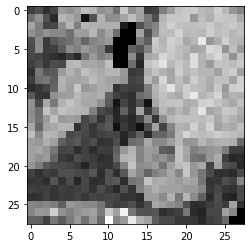

In [8]:
label = {0: 'bladder', 1: 'femur-left', 2: 'femur-right', 3: 'heart', 4: 'kidney-left', 5: 'kidney-right', 6: 'liver', 7: 'lung-left', 8: 'lung-right', 9: 'pancreas', 10: 'spleen'}

x, y = train_dataset[5]
x = np.array(np.squeeze(x))
y = int(y)
print("Dimensions of image =",x.shape)
print("Label =",label[y])
plt.imshow(x,cmap='gray')
plt.show()

Label = liver


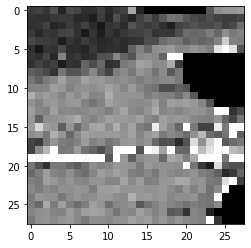

In [9]:
x, y = train_dataset[2]
x=np.array(np.squeeze(x))
y=int(y)
print("Label =",label[y])
plt.imshow(x,cmap='gray')
plt.show()

Label = kidney-right


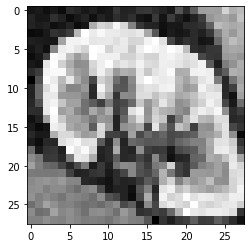

In [10]:
x, y = train_dataset[0]
x=np.array(np.squeeze(x))
y=int(y)
print("Label =",label[y])
plt.imshow(x,cmap='gray')
plt.show()

### Training CNN model on MedMNIST

In [ ]:
NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


In [ ]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 704/704 [01:31<00:00,  7.66it/s]


In [ ]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.967  acc:0.713
test  auc: 0.932  acc:0.556
